In [1]:
# Importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from skimage.measure import compare_ssim as ssim

In [50]:
## defining file paths

train_path = "./data2/faces/"
test_path = "./data/unclassified/"

In [51]:
## loading files

trainfiles = os.listdir(train_path)
trainfiles = [os.path.join(train_path,x) for x in trainfiles]

In [54]:
def init_eigenfaces(trainfiles,K):
    
    """
        Method to initialize the eigenface system.
    """
    
    ## reading the images and vectorizing them
    imgs = []
    for file in trainfiles:
        
        img = cv2.resize(cv2.imread(file,0),(128,128))
#         img = img.reshape(img.size,-1)
        img = img.flatten()
    
        imgs.append(img)
    
    imgs = np.array(imgs)
    imgs = np.squeeze(imgs)
    imgs = imgs.T
    
    imgs = np.float32(imgs)
    
    psi = np.mean(imgs,axis = 1,keepdims = True)
    
    phi = imgs - psi
    
    A = phi.copy()
    A_T = phi.T
    
    C_T = np.matmul(A_T,A)
    
    w,v = np.linalg.eigh(C_T)
        
    u = np.matmul(A,v)
    u_ = u / np.linalg.norm(u,axis = 0)
    
    u_ = u_[:,-K:]
        
    return u_,psi

In [55]:
def show_eigenfaces(u):
    
    """
        Method to display the eigenface
    """
    
    imgs = []
    for j in range(u.shape[1]):
        
        imgs.append(u[:,j].reshape(128,128))
        
    fig,ax = plt.subplots(len(imgs),1,figsize = (30,30))
    
    for e,img in enumerate(imgs):
        
        ax[e].imshow(img,cmap = "gray")
        
    plt.show()

Shape of eigenfaces (16384, 19)


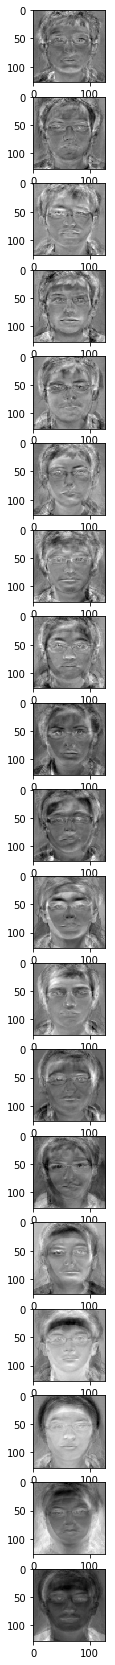

In [100]:
K = 19
u,mean_face = init_eigenfaces(trainfiles,K)

print("Shape of eigenfaces",u.shape)

# plt.figure(figsize = (7,7))
# plt.title("Mean Face")
# plt.imshow(mean_face.reshape(128,128),cmap = "gray")
# plt.show()

show_eigenfaces(u)

In [125]:
def reconstruct_img(img,mean_face,u,visualize = False):
    
    """
        Method to reconstruct face image
    """
    
    ## vectorize the image
    img_ = img.flatten()
    img_ = np.expand_dims(img_,axis = 1)

    ## subtract mean face
    img_ = img_ - mean_face
    
    recon = 0.0
    for j in range(K):
    
        wj1 = np.matmul(np.reshape(u[:,j],(u[:,j].size,1)).T,np.reshape(img_,(img_.size,1)))
        recon = recon + wj1*u[:,j]
    
    recon = np.reshape(recon,(128,128))
    
    if(visualize):
        fig,ax = plt.subplots(1,2,figsize = (15,15))
        ax[0].imshow(img,cmap = "gray")
        ax[0].set_title("original image")
        ax[1].imshow(recon,cmap = "gray")
        ax[1].set_title("reconstructed image")
        plt.show()

    recon_ = img.std() * ((recon - recon.mean()) / recon.std()) + img.mean()
        
    return recon,ssim(img,recon_,data_range = recon_.max() - recon_.min())

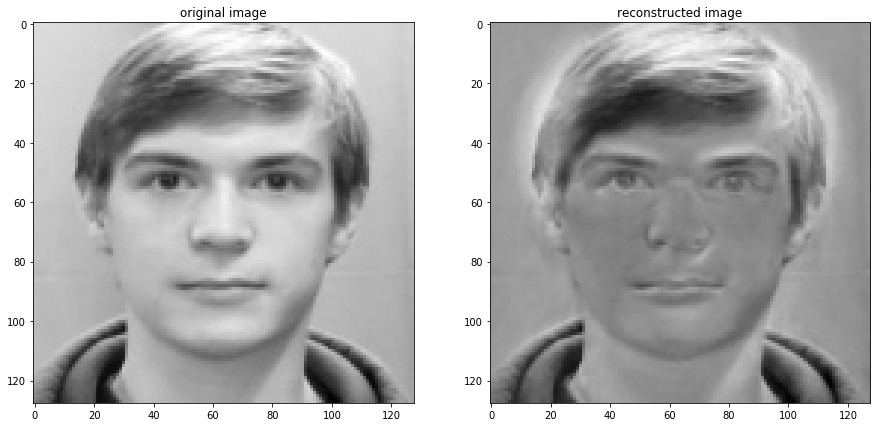

ssim:  0.7695736909396244


In [127]:
path = os.path.join(train_path,"img02.png")
img = cv2.imread(path,0)
img = np.float32(cv2.resize(img,(128,128)))

_,ssim_ = reconstruct_img(img,mean_face,u,visualize = True)
print("ssim: ",ssim_)

## Face Detection

In [128]:
K = 19
u,mean_face = init_eigenfaces(trainfiles,K)

In [136]:
def face_detect(path,thresh):
    unk_img = cv2.imread(path,0)
    unk_img = np.float32(cv2.resize(unk_img,(128,128)))

    ## compute the reconstructed image
    recon,ssim_ = reconstruct_img(unk_img,mean_face,u,visualize = True)
    print(ssim_)
    
    ## normalizing img and recon
    unk_img = ((unk_img - unk_img.min()) / (unk_img.max() - unk_img.min())) 
    recon = ((recon - recon.min()) / (recon.max() - recon.min()))

    ## calculate the error
    error = np.linalg.norm(unk_img - recon)
    
    isface = False
    if(ssim_ > thresh):
        isface = True
        
    return error,isface

In [137]:
testfiles = os.listdir(test_path)
testfiles = [os.path.join(test_path,x) for x in testfiles]

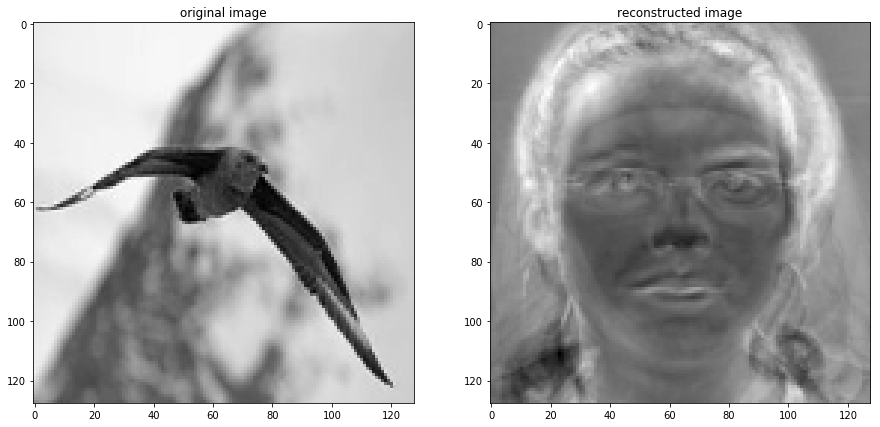

0.2577177300587085
./data/unclassified/img08.png False


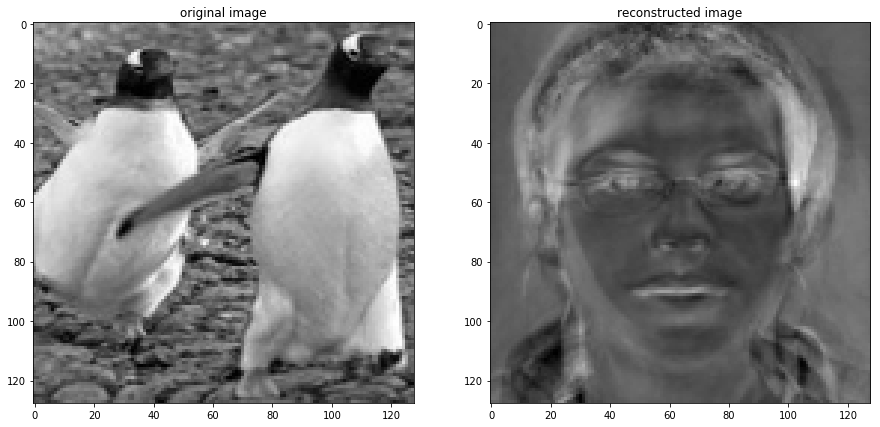

0.21408821164207267
./data/unclassified/img06.png False


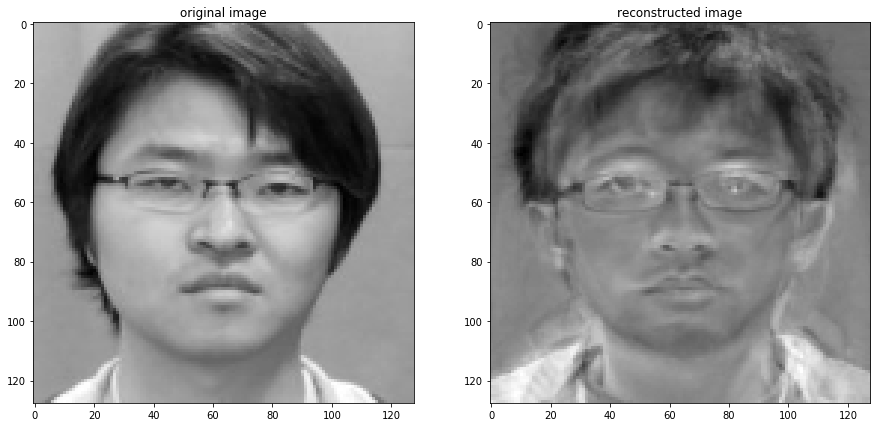

0.3447400623001693
./data/unclassified/img01.png True


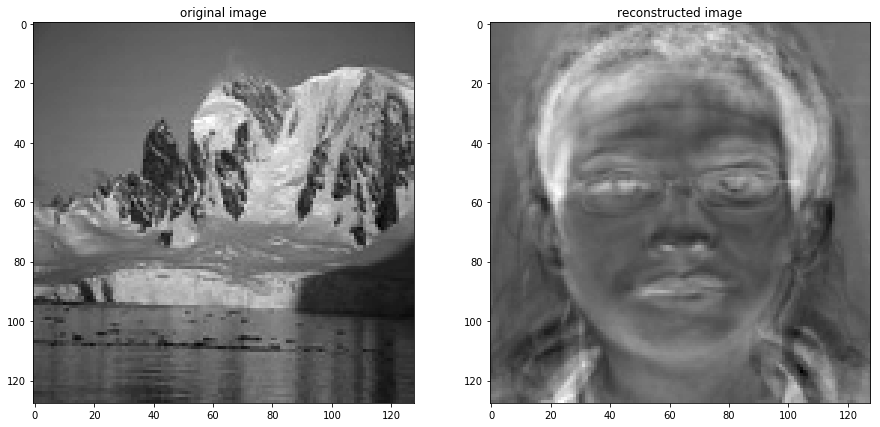

0.1751920392345497
./data/unclassified/img07.png False


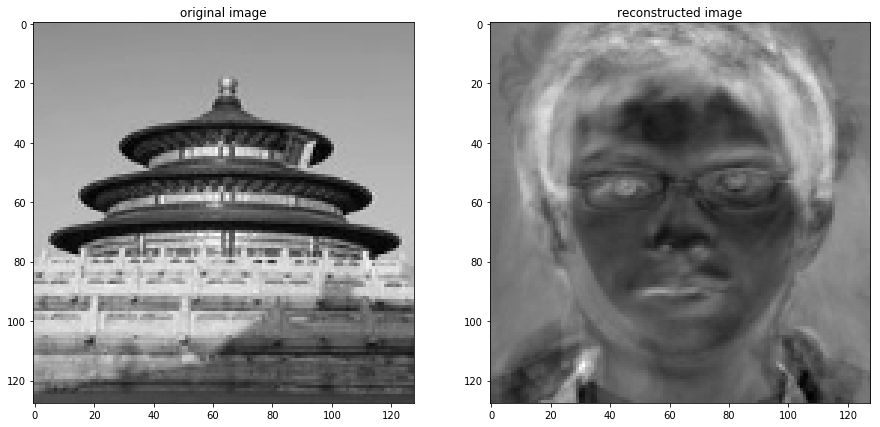

0.15873727284030736
./data/unclassified/img09.png False


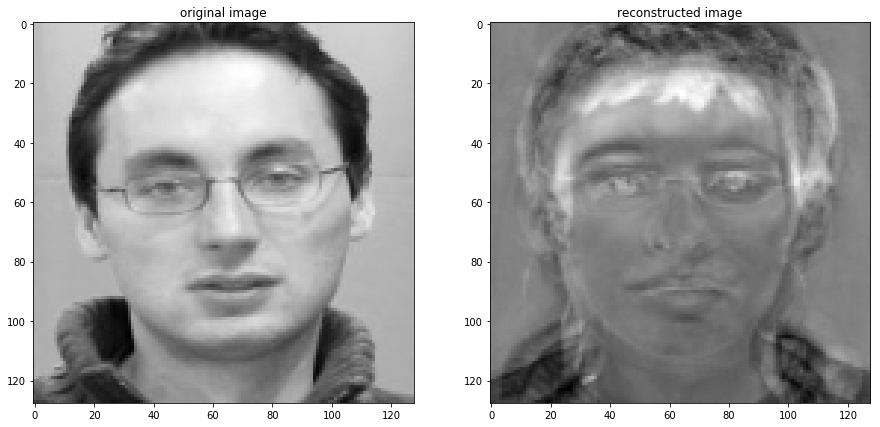

0.37302573788834276
./data/unclassified/img05.png True


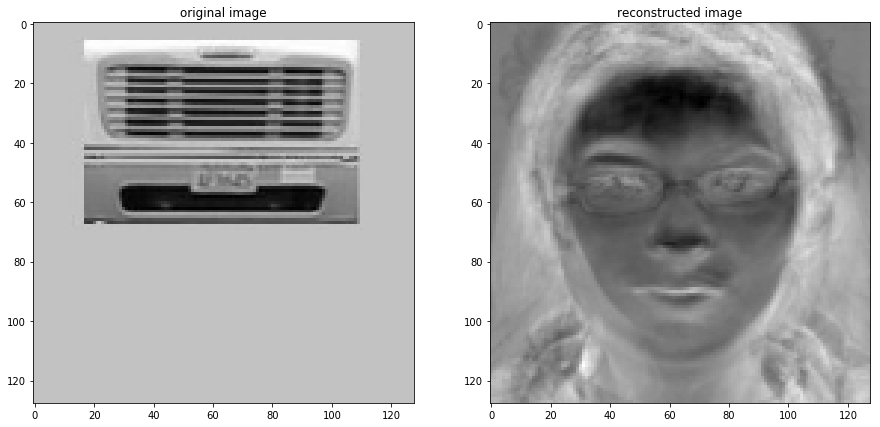

0.2919093739199156
./data/unclassified/img00.png True


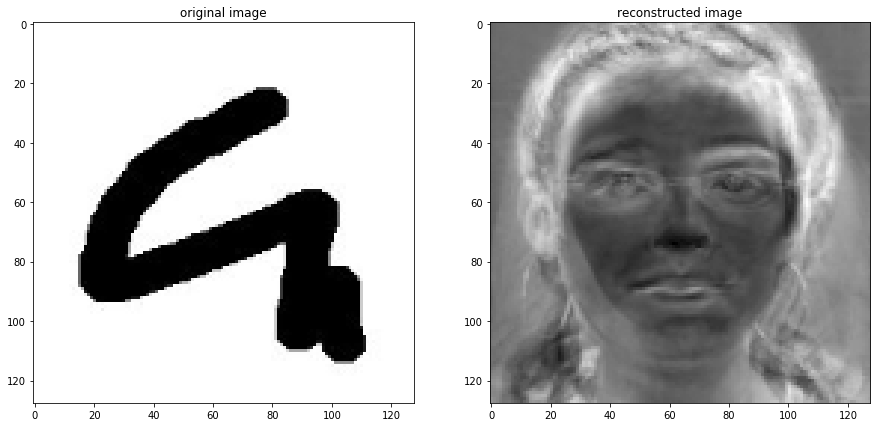

0.21046422769731293
./data/unclassified/img10.png False


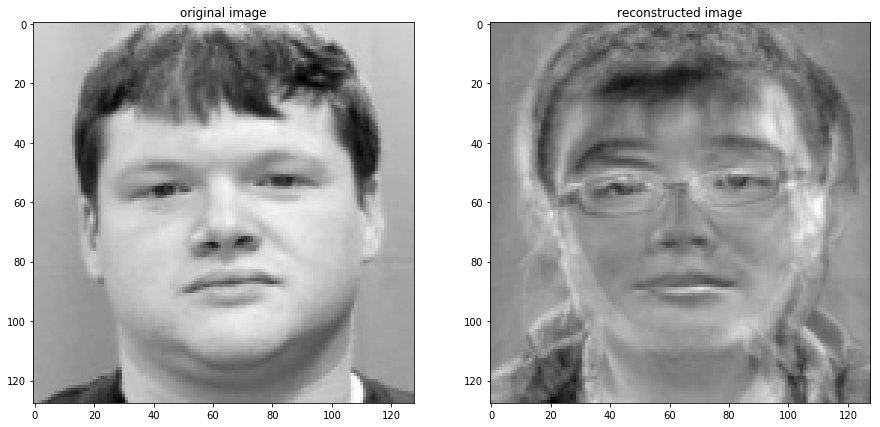

0.33949878163374625
./data/unclassified/img04.png True


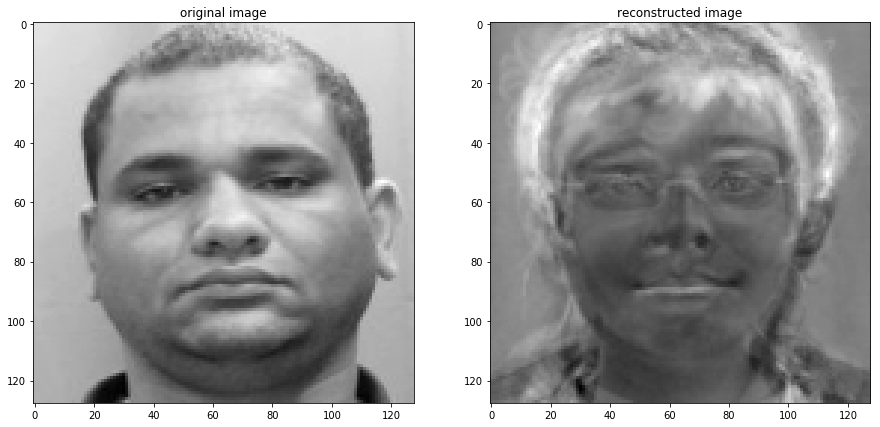

0.30455296824018013
./data/unclassified/img02.png True


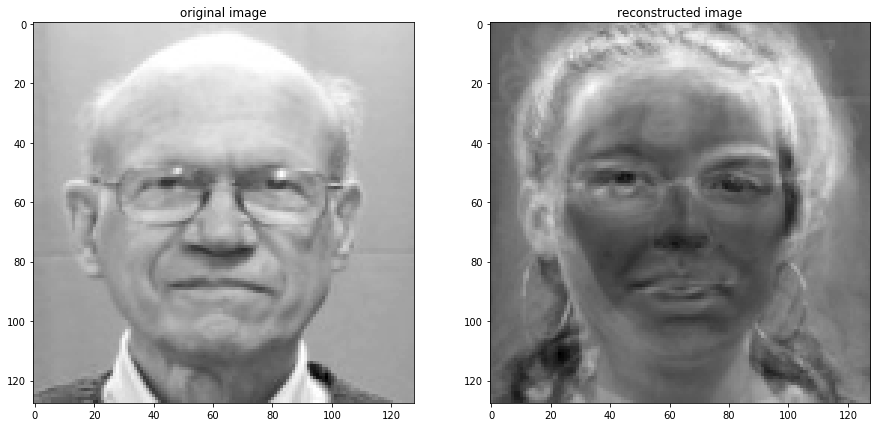

0.2423725695013161
./data/unclassified/img03.png False


In [140]:
## compare face detection, SSIM also displayed

for file in testfiles:
    
    thresh = 0.26
    error,isface = face_detect(file,thresh)
    print(file,isface)

## Face Recognition

In [153]:
def face_recog(unk_img,trainfiles,u):

    """
        Method to perform face recognition
    """
    
    unk_img = unk_img.flatten()
    unk_img = unk_img.reshape(unk_img.size,1)
    
    unk_w = np.matmul(u.T,unk_img)
        
    distance = 1000000.0
    file = ""
        
    for file in trainfiles:
        
        img = cv2.resize(cv2.imread(file,0),(128,128))
        img = img.flatten()
        img = img.reshape(img.size,1)
        
        w = np.matmul(u.T,img)
        
        if(distance > np.linalg.norm(w - unk_w)):
            distance = np.linalg.norm(w - unk_w)
            recog_file = file
    
    return recog_file

In [157]:
path = os.path.join(train_path,"img01.png")
img = cv2.imread(path,0)
img = np.float32(cv2.resize(img,(128,128)))

face_recog(img,trainfiles,u)

'./data2/faces/img01.png'